## Project Lighthouse - Visionary Model (v0.1)

This is a Feedforward Neural Network that assists the prediction of individuals at risk of homelessness. It is built on **Tensorflow Keras**, and trains on the data created by *generator.ipynb*.

**Data Features**:
- Gender (binary)
- Age (one-hot encoded: 7 age ranges from 0-17 to 65+)
- Drug, Mental, Indigenous, DV (binary risk factors)
- Location (one-hot encoded: ACT, NSW, NT, QLD, SA, TAS, VIC, WA)
- SHS_Client (binary indicator)
- Target: Homeless (binary)

In [42]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### **1. Preprocessing**

*Importing our synthetic data, generated by generator.ipynb, and display its details.*

In [43]:
df = pd.read_csv("/Users/arona/Documents/GitHub/Visionary-Model/model/data/synthetic_homelessness_data.csv")
print(f"Loaded samples, {len(df):,} rows, {df.shape[1]} attributes ")

Loaded samples, 100,000 rows, 15 attributes 


As we are predicting homelessness (Y) with background (X):
$$Y = Dataset_{Homelessness}$$
$$X = Dataset - Dataset_{Homelessness}$$

In [44]:
# Extract 'Homeless' value as Y
y = df['Homeless'].values
print(f"Target prevalence: {y.mean() * 100}% homeless ({y.sum():,} of {len(y):,})")

# Extract all columns other than 'Homeless' as X
feature_cols = [c for c in df.columns if c != 'Homeless']
X = df[feature_cols].copy()

Target prevalence: 49.905% homeless (49,905 of 100,000)


Express Booleans as Binary (1 & 0s)

In [45]:
# X - Encode Boolean values into binary
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

print(f"X Sample: \n{X.head(3)}")
print(f"Y Sample: \n{y[:3]}")

X Sample: 
   Gender  Age  Drug  Mental  Indigenous  DV  Location_ACT  Location_NSW  \
0       0   39     0       0           0   0             0             0   
1       1   28     0       0           0   0             0             0   
2       0   58     0       0           0   0             0             0   

   Location_NT  Location_QLD  Location_SA  Location_TAS  Location_VIC  \
0            0             0            0             0             1   
1            0             0            0             0             1   
2            0             1            0             0             0   

   Location_WA  
0            0  
1            0  
2            0  
Y Sample: 
[1 1 0]


Normalise $X_{age}$ to provide it in similar scale to other attributes. 

Using ```sklearn.preprocessing.StandardScaler.fit_transform()```, which is Z-Score Normalisation:

$$Z = \frac{X - \mu}{\sigma}$$

Where:
 - $\mu$ = Mean
 - $\sigma$ = Standard Deviation

In [46]:
from sklearn.preprocessing import StandardScaler

# --- Scale Age only ---
scaler = StandardScaler()

X["Age"] = scaler.fit_transform(X[["Age"]])

print("Scaled Age mean:", X["Age"].mean().round(4), "std:", X["Age"].std().round(4))

print(X["Age"][:5])

Scaled Age mean: -0.0 std: 1.0
0   -0.044659
1   -0.501725
2    0.744818
3    0.495510
4    0.204650
Name: Age, dtype: float64


Split the dataset into Train & Test with ```sklearn.model_selection.train_test_split()```, with 80% train and 20% test.

In [47]:
# Split train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42, stratify=y
)

### **2. Model Training**

Using ```keras.Sequential``` to create a MLP (Multi-Layered Perceptron) model:
 - Using ```keras.activations.relu``` as activation for hidden layers for more efficient training

$$\text{ReLU}(x) = \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{if } x \le 0
\end{cases}$$

 - Using ```keras.layers.sigmoid``` to squeeze prediction into probabilistic value between 0 and 1.0

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

In [48]:
model = keras.Sequential([
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Initial approach of using ```keras.losses.Tversky``` with alpha beta of 0.2 & 0.8 to punish false negatives, preventing bias that may predict all samples as "Not Homeless".

Tversky loss is commonly used in medical fields such as skin cancer detection, where due to large amounts of data, FNs may still yield high accuracy. Tversky punishes this with its alpha & beta parameters that determines the weight of FP & FN. 

It is defined by:

$$
\mathcal{L}_{Tversky}(y, \hat{y}) = 1 - \frac{\sum_i y_i \hat{y}_i}
{\sum_i y_i \hat{y}_i + \alpha \sum_i y_i (1 - \hat{y}_i) + \beta \sum_i (1 - y_i)\hat{y}_i}
$$

Where:
- $y_i$ is the ground truth label,
- $\hat{y}_i$ is the predicted probability,
- $\alpha$ and $\beta$ are parameters controlling the penalty for false negatives and false positives respectively.


---

Switched to ```keras.losses.BinaryCrossentropy``` as it yields higher acuracy. 

In [49]:
loss = keras.losses.Tversky(alpha=0.4, beta=0.6, name="tversky")
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(), # alternative tversky loss - loss
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

In [50]:
X_train_array = X_train.values
X_test_array = X_test.values

history = model.fit(
    X_train_array, y_train,
    validation_data=(X_test_array, y_test),
    epochs=25,
    batch_size=256, 
    verbose=1
)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5881 - auc: 0.6227 - loss: 0.6672 - val_accuracy: 0.6167 - val_auc: 0.6622 - val_loss: 0.6496
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6117 - auc: 0.6545 - loss: 0.6537 - val_accuracy: 0.6187 - val_auc: 0.6654 - val_loss: 0.6488
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - auc: 0.6574 - loss: 0.6524 - val_accuracy: 0.6181 - val_auc: 0.6636 - val_loss: 0.6505
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6157 - auc: 0.6602 - loss: 0.6510 - val_accuracy: 0.6170 - val_auc: 0.6657 - val_loss: 0.6487
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - auc: 0.6599 - loss: 0.6507 - val_accuracy: 0.6176 - val_auc: 0.6663 - val_loss: 0.6482
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - auc: 0.6594 - loss: 0.6510 - val_accuracy: 0.6183 - val_auc: 0.6628 - val_loss: 0.6499
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 

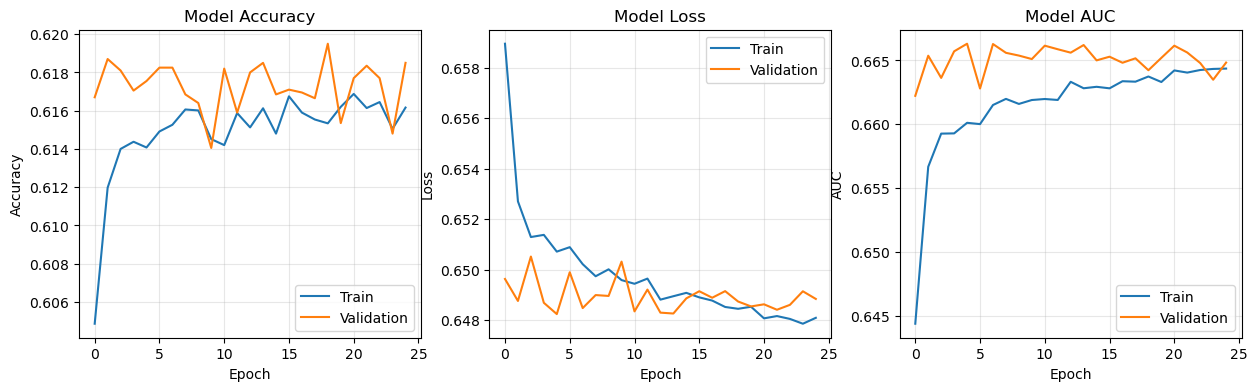

In [51]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['auc'], label='Train')
axes[2].plot(history.history['val_auc'], label='Validation')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Model AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)